In [1]:
# Importar las bibliotecas necesarias para procesamiento de audio, visualización y manipulación de datos
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from scipy.fft import fft, ifft
import pandas as pd
import noisereduce as nr

/opt/miniconda3/envs/st/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Función para normalizar el audio
def normalizar_audio(audio):
    return (audio - np.mean(audio)) / np.std(audio)

In [3]:
# Función para aplicar filtro de media móvil
def filtro_media_movil(signal, window_size):
    return np.convolve(signal, np.ones(window_size) / window_size, mode='same')

In [4]:
# Función para calcular SNR
def calcular_snr(signal, noise):
    signal_power = np.sum(signal ** 2)
    noise_power = np.sum(noise ** 2)
    return 10 * np.log10(signal_power / noise_power)


In [5]:
# Cargar el audio original y el ruido
audio_original_path = '../tp/datos/audios/original/audio.wav'
audio_original, sr_audio_original = librosa.load(audio_original_path, sr=None)
ruido_path = '../tp/datos/audios/original/ruido.wav'
ruido, sr_ruido = librosa.load(ruido_path, sr=None)

In [6]:
# Normalizar el audio
audio_original = normalizar_audio(audio_original)
ruido = normalizar_audio(ruido)

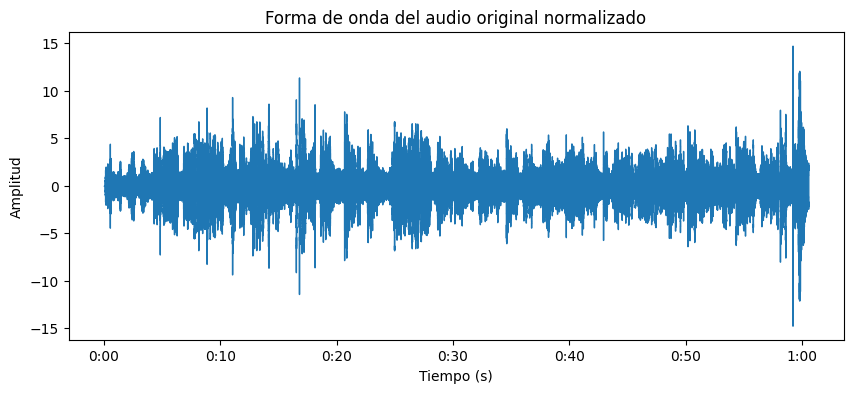

In [7]:
# Visualizar y guardar la forma de onda del audio original
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio_original, sr=sr_audio_original)
plt.title('Forma de onda del audio original normalizado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.savefig('waveform_original.png')
plt.show()

In [8]:
# Aplicar filtro de media móvil en el audio original
duracion_ventana_ms = 5  # Duración de la ventana en milisegundos
tamano_ventana = int(sr_audio_original * duracion_ventana_ms / 1000)  # Convertir a muestras
print(tamano_ventana)
audio_mm = filtro_media_movil(audio_original, tamano_ventana)

240


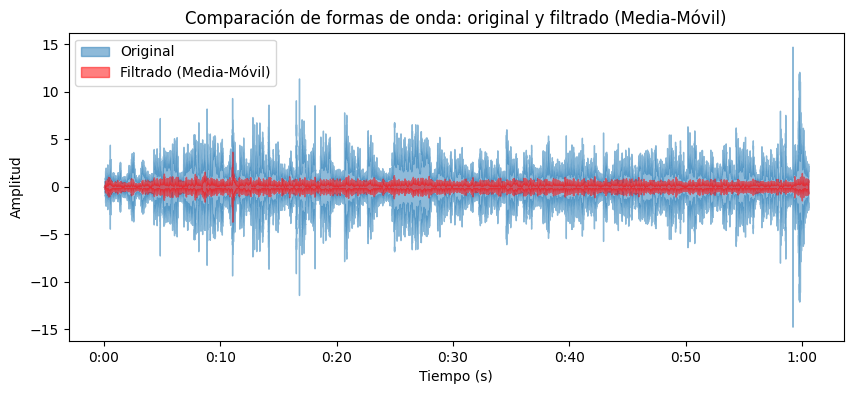

In [9]:
# Comparar formas de onda: original vs filtrado pasa-banda
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio_original, sr=sr_audio_original, alpha=0.5, label='Original')
librosa.display.waveshow(audio_mm, sr=sr_audio_original, color='r', alpha=0.5, label='Filtrado (Media-Móvil)')
plt.title('Comparación de formas de onda: original y filtrado (Media-Móvil)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.savefig('moving_average_waveform_comparison.png')
plt.show()

In [10]:
# Aplicar la Transformada de Fourier en el audio original
fourier_audio_original = fft(audio_original)
frecuencias_originales = np.fft.fftfreq(len(fourier_audio_original), 1 / sr_audio_original)

In [11]:
# Crear y aplicar un filtro pasa-banda
frecuencia_corte_alta = 4000  # Frecuencia de corte superior
frecuencia_corte_baja = 80     # Frecuencia de corte inferior
mascara_filtro = (np.abs(frecuencias_originales) >= frecuencia_corte_baja) & (np.abs(frecuencias_originales) <= frecuencia_corte_alta)
audio_pasa_banda_original = fourier_audio_original * mascara_filtro
dt_audio_pasa_banda_original = np.real(ifft(audio_pasa_banda_original))

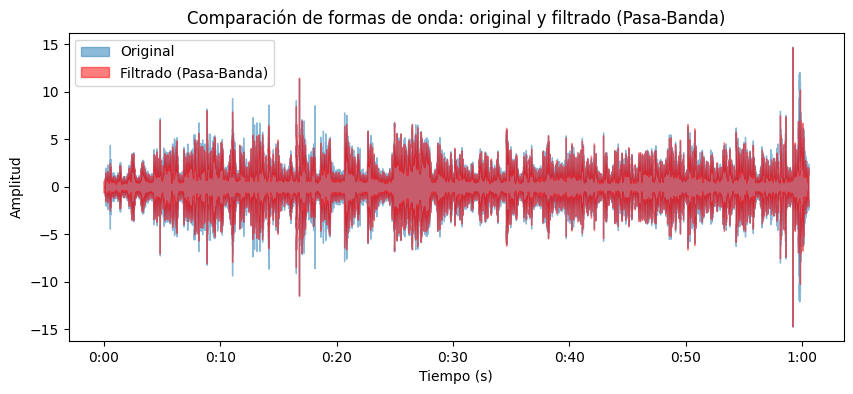

In [12]:
# Comparar formas de onda: original vs filtrado
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio_original, sr=sr_audio_original, alpha=0.5, label='Original')
librosa.display.waveshow(dt_audio_pasa_banda_original, sr=sr_audio_original, color='r', alpha=0.5, label='Filtrado (Pasa-Banda)')
plt.title('Comparación de formas de onda: original y filtrado (Pasa-Banda)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.savefig('bandpass_waveform_comparison.png')
plt.show()

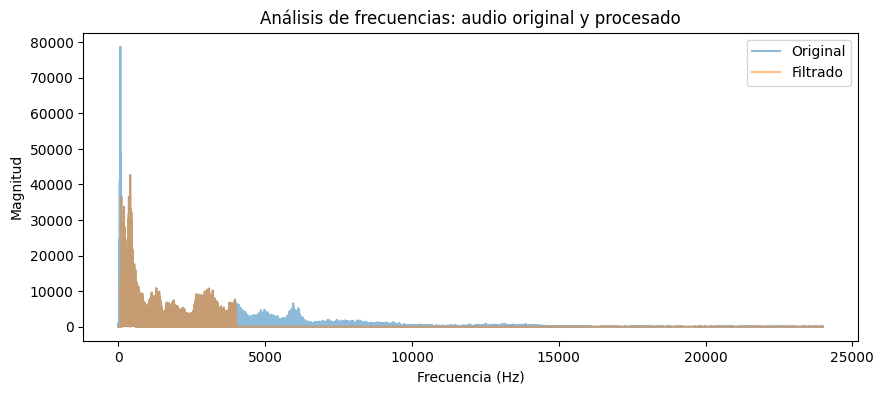

In [13]:
# Análisis de frecuencias del audio original y procesado
magnitud_original = np.abs(fourier_audio_original[:len(fourier_audio_original)//2])
magnitud_filtrado = np.abs(fft(dt_audio_pasa_banda_original)[:len(fourier_audio_original)//2])

plt.figure(figsize=(10, 4))
plt.plot(frecuencias_originales[:len(fourier_audio_original)//2], magnitud_original, label='Original', alpha=0.5)
plt.plot(frecuencias_originales[:len(fourier_audio_original)//2], magnitud_filtrado, label='Filtrado', alpha=0.5)
plt.title('Análisis de frecuencias: audio original y procesado')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.legend()
plt.savefig('frequency_analysis.png')
plt.show()

In [14]:
# Reducción de ruido usando Deep Learning
audio_reduccion_ruido = nr.reduce_noise(y=audio_original, sr=sr_audio_original, y_noise=ruido)

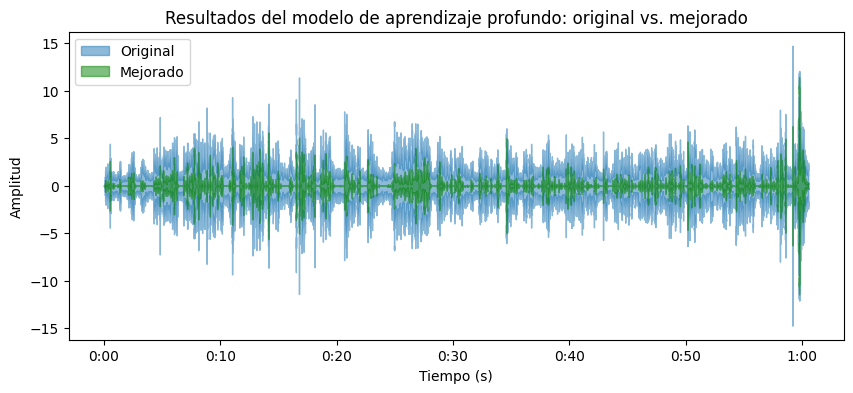

In [15]:
# Resultado del modelo de Deep Learning
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio_original, sr=sr_audio_original, alpha=0.5, label='Original')
librosa.display.waveshow(audio_reduccion_ruido, sr=sr_audio_original, color='g', alpha=0.5, label='Mejorado')
plt.title('Resultados del modelo de aprendizaje profundo: original vs. mejorado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.savefig('deep_learning_results.png')
plt.show()

In [17]:
# Guardar archivos de audio procesados
sf.write('./resultados/audio_reducido_ruido_dl.wav', audio_reduccion_ruido, sr_audio_original)
sf.write('./resultados/audio_filtrado_pasa_banda.wav', dt_audio_pasa_banda_original, sr_audio_original)
sf.write('./resultados/audio_filtrado_media_movil.wav', audio_mm, sr_audio_original)